In [1]:
#!pip install llvmlite --ignore installed
#!pip install dcor --ignore-installed

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.stats import pearsonr
import statsmodels.api as sm
#import dcor

### Helper Functions ###

In [3]:
def percent2float(data):
    output = []
    for x in data:
        output.append(float(x.strip('%'))/100)
        
    return output

def str2int(data):
    output = []
    for x in data:
        output.append(int(x))
        
    return output

def money2int(data):
    output = []
    for x in data:
        output.append(int(x.strip('$').replace(',', '')))
        
    return output

# Preliminary QHP data EDA #

In [4]:
qhp_data = pd.read_excel('data\individual_qhp19.xlsx', sheet_name='Individual_Market_Medical')

In [5]:
for col in qhp_data.columns:
    print(col)

State Code
FIPS County Code
County Name
Metal Level
Issuer Name
HIOS Issuer ID
Plan ID (Standard Component)
Plan Marketing Name
Plan Type
Rating Area
Child Only Offering
Source
Customer Service Phone Number Local
Customer Service Phone Number Toll Free
Customer Service Phone Number TTY
Network URL
Plan Brochure URL
Summary of Benefits URL
Drug Formulary URL
Accreditation
Adult Dental 
Child Dental 
EHB Percent of Total Premium
Premium Scenarios
Premium Child Age 0-14
Premium Child Age 18
Premium Adult Individual Age 21
Premium Adult Individual Age 27
Premium Adult Individual Age 30 
Premium Adult Individual Age 40 
Premium Adult Individual Age 50 
Premium Adult Individual Age 60 
Premium Couple 21  
Premium Couple 30 
Premium Couple 40 
Premium Couple 50 
Premium Couple 60 
Couple+1 child, Age 21
Couple+1 child, Age 30 
Couple+1 child, Age 40 
Couple+1 child, Age 50 
Couple+2 children, Age 21
Couple+2 children, Age 30 
Couple+2 children, Age 40 
Couple+2 children, Age 50
Couple+3 or mo

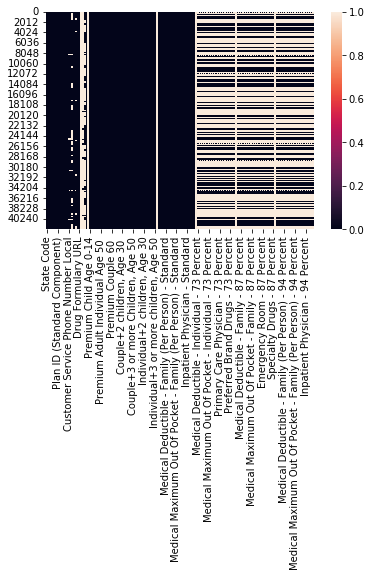

In [6]:
sns.heatmap(qhp_data.isnull())

In [7]:
print(len(qhp_data.isna().any()[qhp_data.isna().any() == False])/len(qhp_data.columns), " of the columns have no nans")

0.4966442953020134  of the columns have no nans


In [8]:
#extract useful variables and convert dental columns to binary
qhp = qhp_data[['HIOS Issuer ID', 'State Code', 'Plan ID (Standard Component)', 'Metal Level', 'Issuer Name', 'Plan Type', 'Adult Dental ', 'Child Dental ', 'EHB Percent of Total Premium']]
columns = ['issuer_id', 'state', 'plan_id', 'metal', 'issuer', 'plan_type', 'adult_dental', 'child_dental', 'EHB_over_premium']
qhp.columns = columns

qhp = qhp.fillna(0)
qhp = qhp.replace('X', 1)

print(qhp['adult_dental'].value_counts())
print(qhp['child_dental'].value_counts())

0    40226
1     2010
Name: adult_dental, dtype: int64
0    25685
1    16551
Name: child_dental, dtype: int64


In [9]:
#dealing with duplicate plan id's
# there are duplicates because plan ids are recorded separately by county so have to check if EHB varies
plan_ids = set(qhp['plan_id'])
for plan in plan_ids:
    ehbs = qhp[qhp['plan_id'] == plan]['EHB_over_premium']
    
    if len(set(ehbs)) > 1:
        print('EHBs vary within plan id')
        break

In [10]:
#since they don't differ by county, can drop duplicates
print('length of qhp before dropping duplicates: ', len(qhp))
qhp = qhp.drop_duplicates()
print('length of qhp after dropping duplicates: ', len(qhp))

length of qhp before dropping duplicates:  42236
length of qhp after dropping duplicates:  2659


In [11]:
qhp.columns

Index(['issuer_id', 'state', 'plan_id', 'metal', 'issuer', 'plan_type',
       'adult_dental', 'child_dental', 'EHB_over_premium'],
      dtype='object')

# Preliminary quality data EDA #

In [13]:
quality_data = pd.read_csv('data\quality20.csv')

In [14]:
quality_data

,IssuerID,State,Plan Type,ReportingUnitID,PlanID,OverallRatingValue,MedicalCareRatingValue,MemberExperienceRatingValue,PlanAdministrationRatingValue,NotRatedReason_OverallRatingDesc,NotRatedReason_MedicalCareRatingDesc,NotRatedReason_MemberExperienceRatingDesc,NotRatedReason_PlanAdministrationRatingDesc
0,10091,OR,PPO,10091-OR-PPO,10091OR0680001,3,3,3,4,NaN,NaN,NaN,NaN
1,10091,OR,PPO,10091-OR-PPO,10091OR0680002,3,3,3,4,NaN,NaN,NaN,NaN
2,10091,OR,PPO,10091-OR-PPO,10091OR0680003,3,3,3,4,NaN,NaN,NaN,NaN
3,10091,OR,PPO,10091-OR-PPO,10091OR0680004,3,3,3,4,NaN,NaN,NaN,NaN
4,10091,OR,PPO,10091-OR-PPO,10091OR0680005,3,3,3,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3506,99969,OH,HMO,99969-OH-HMO,99969OH0080187,3,3,3,3,NaN,NaN,NaN,NaN
3507,99969,OH,HMO,99969-OH-HMO,99969OH0080188,3,3,3,3,NaN,NaN,NaN,NaN
3508,99969,OH,HMO,99969-OH-HMO,99969OH0080189,3,3,3,3,NaN,NaN,NaN,NaN
3509,99969,OH,HMO,99969-OH-HMO,99969OH0080190,3,3,3,3,NaN,NaN,NaN,NaN


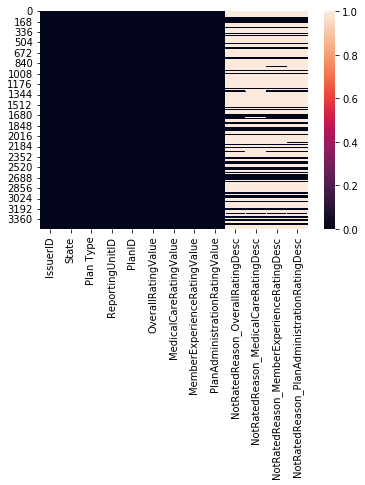

In [15]:
sns.heatmap(quality_data.isnull())

In [16]:
print(quality_data.columns)

Index(['IssuerID', 'State', 'Plan Type', 'ReportingUnitID', 'PlanID',
       'OverallRatingValue', 'MedicalCareRatingValue',
       'MemberExperienceRatingValue', 'PlanAdministrationRatingValue',
       'NotRatedReason_OverallRatingDesc',
       'NotRatedReason_MedicalCareRatingDesc',
       'NotRatedReason_MemberExperienceRatingDesc',
       'NotRatedReason_PlanAdministrationRatingDesc'],
      dtype='object')


In [18]:
#extract relevant columns
qual_data = quality_data[['PlanID', 'OverallRatingValue', 'MedicalCareRatingValue', 'MemberExperienceRatingValue', 'PlanAdministrationRatingValue']]
qual_data = qual_data.replace('NR', np.nan)
qual_data = qual_data.dropna()
qual_data.columns = ['PlanID', 'overall_rating', 'medcare_rating', 'member_exp_rating', 'plan_admin_rating']
qual_data

,PlanID,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating
0,10091OR0680001,3,3,3,4
1,10091OR0680002,3,3,3,4
2,10091OR0680003,3,3,3,4
3,10091OR0680004,3,3,3,4
4,10091OR0680005,3,3,3,4
...,...,...,...,...,...
3506,99969OH0080187,3,3,3,3
3507,99969OH0080188,3,3,3,3
3508,99969OH0080189,3,3,3,3
3509,99969OH0080190,3,3,3,3


## Merge Data ##

In [27]:
merged = qhp.merge(qual_data, left_on='plan_id', right_on='PlanID')
merged

,issuer_id,state,plan_id,metal,issuer,plan_type,adult_dental,child_dental,EHB_over_premium,PlanID,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating
0,10091,OR,10091OR0680001,Catastrophic,PacificSource Health Plans,PPO,0,0,99.99%,10091OR0680001,3,3,3,4
1,10091,OR,10091OR0680002,Bronze,PacificSource Health Plans,PPO,0,0,99.99%,10091OR0680002,3,3,3,4
2,10091,OR,10091OR0680003,Silver,PacificSource Health Plans,PPO,0,0,99.99%,10091OR0680003,3,3,3,4
3,10091,OR,10091OR0680004,Gold,PacificSource Health Plans,PPO,0,0,99.99%,10091OR0680004,3,3,3,4
4,10091,OR,10091OR0680005,Catastrophic,PacificSource Health Plans,PPO,0,0,99.99%,10091OR0680005,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,99969,OH,99969OH0080113,Silver,Medical Health Insuring Corp. of Ohio,HMO,0,0,100.00%,99969OH0080113,3,3,3,3
1749,99969,OH,99969OH0080114,Expanded Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,100.00%,99969OH0080114,3,3,3,3
1750,99969,OH,99969OH0080115,Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,100.00%,99969OH0080115,3,3,3,3
1751,99969,OH,99969OH0080116,Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,100.00%,99969OH0080116,3,3,3,3


## Fix Values ##

In [28]:
type(merged['overall_rating'][0])

str

In [29]:
merged['EHB_over_premium'] = percent2float(merged['EHB_over_premium'])
quality_metrics = ['overall_rating', 'medcare_rating', 'member_exp_rating', 'plan_admin_rating']
for qual in quality_metrics:
    merged[qual] = str2int(merged[qual])

In [31]:
df = merged[['issuer_id', 'state', 'plan_id', 'metal', 'issuer', 'plan_type', 'adult_dental', 'child_dental', 'EHB_over_premium', 'overall_rating', 'medcare_rating', 'member_exp_rating', 'plan_admin_rating']]
df.describe()

,issuer_id,adult_dental,child_dental,EHB_over_premium,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating
count,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000,1753.000000
mean,50821.985168,0.030804,0.367370,0.997481,3.060468,2.606389,3.023388,3.180833
std,26425.241003,0.172837,0.482226,0.008593,0.643545,0.716094,0.731718,0.687327
min,10091.000000,0.000000,0.000000,0.930200,1.000000,1.000000,1.000000,1.000000
25%,32225.000000,0.000000,0.000000,1.000000,3.000000,2.000000,3.000000,3.000000
50%,38166.000000,0.000000,0.000000,1.000000,3.000000,3.000000,3.000000,3.000000
75%,75605.000000,0.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000
max,99969.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000


In [32]:
df['state'].value_counts()

TX    307
GA    199
WI    155
IL    113
OH    106
PA     96
FL     77
AZ     75
MI     58
NC     53
MT     47
NM     44
VA     43
OK     40
UT     38
LA     30
SC     28
KY     25
HI     23
SD     23
OR     20
TN     20
NJ     18
IN     17
ND     15
AR     13
WV     11
NH     11
MO     10
WY     10
AL      7
DE      7
ME      7
AK      5
MS      2
Name: state, dtype: int64

# MLR #

In [33]:
mlr = pd.read_csv('data\mlr19.csv')
mlr

,COMPANY NAME,ISSUER STATE,ISSUER CODE,STATE NAME,MLR STANDARD - INDIVIDUAL MARKET,ISSUER'S MLR - INDIVIDUAL MARKET,AVERAGE REBATE - INDIVIDUAL MARKET,MLR STANDARD - SMALL GROUP MARKET,ISSUER'S MLR - SMALL GROUP MARKET,AVERAGE REBATE - SMALL GROUP MARKET,MLR STANDARD - LARGE GROUP MARKET,ISSUER'S MLR - LARGE GROUP MARKET,AVERAGE REBATE - LARGE GROUP MARKET,ADDITIONAL STATE TEXT
0,Aetna Health Inc. (a Florida corporation),FL,18628,Florida,0.8,88.2%,$0 (Meets MLR Standard),0.8,80.3%,$0 (Meets MLR Standard),0.85,87.5%,$0 (Meets MLR Standard),NaN
1,Aetna Health Inc. (a Georgia corporation),GA,82824,Georgia,NaN,No Business Reported,NaN,1.0,79.8%,$13,0.85,88.2%,$0 (Meets MLR Standard),NaN
2,Aetna Health Inc. (a Maine corporation),ME,73250,Maine,NaN,No Business Reported,NaN,0.8,91.8%,$0 (Meets MLR Standard),0.85,89.5%,$0 (Meets MLR Standard),NaN
3,Aetna Health Inc. (a New Jersey corporation),NJ,82884,New Jersey,NaN,No Business Reported,NaN,0.8,101.1%,$0 (Meets MLR Standard),0.85,90.8%,$0 (Meets MLR Standard),NaN
4,Aetna Health Inc. (a Texas corporation),TX,58840,Texas,NaN,No Business Reported,NaN,0.8,93.8%,$0 (Meets MLR Standard),0.85,91.8%,$0 (Meets MLR Standard),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,Oscar Insurance Company of Florida,FL,40572,Florida,0.8,92.9%,$0 (Meets MLR Standard),NaN,No Business Reported,NaN,NaN,No Business Reported,NaN,NaN
1266,"HealthPartners UnityPoint Health, Inc.",IA,45720,Iowa,NaN,No Business Reported,NaN,NaN,No Business Reported,NaN,0.85,113.9%,$0 (Meets MLR Standard),NaN
1267,Memorial Hermann Commercial Health Plan,TX,75655,Texas,NaN,No Business Reported,NaN,0.8,119.5%,$0 (Meets MLR Standard),0.85,102.6%,$0 (Meets MLR Standard),NaN
1268,Scott & White Care Plans,TX,31009,Texas,NaN,No Business Reported,NaN,NaN,No Business Reported,NaN,0.85,82.9%,$114,NaN


In [34]:
#lets get notes about mlr
for i in set(mlr['ADDITIONAL STATE TEXT'].dropna()):
    print(i)
    print('\n')

In Massachusetts, in the individual and small group markets, most health insurers must meet an 88% Medical Loss Ratio in 2019.


In New York, in the individual and small group markets, most health insurers must meet an 82% Medical Loss Ratio in 2019.




In [35]:
mlr.columns

Index(['COMPANY NAME', 'ISSUER STATE', 'ISSUER CODE', 'STATE NAME',
       'MLR STANDARD - INDIVIDUAL MARKET', 'ISSUER'S MLR - INDIVIDUAL MARKET',
       'AVERAGE REBATE - INDIVIDUAL MARKET',
       'MLR STANDARD - SMALL GROUP MARKET',
       'ISSUER'S MLR - SMALL GROUP MARKET',
       'AVERAGE REBATE - SMALL GROUP MARKET',
       'MLR STANDARD - LARGE GROUP MARKET',
       'ISSUER'S MLR - LARGE GROUP MARKET',
       'AVERAGE REBATE - LARGE GROUP MARKET', 'ADDITIONAL STATE TEXT'],
      dtype='object')

In [36]:
mlr = mlr[['ISSUER CODE', 'ISSUER STATE', 'MLR STANDARD - INDIVIDUAL MARKET', "ISSUER'S MLR - INDIVIDUAL MARKET", 'AVERAGE REBATE - INDIVIDUAL MARKET']]
mlr.columns = ['issuer_id', 'state', 'required_mlr', 'mlr', 'average_rebate']
mlr.columns

Index(['issuer_id', 'state', 'required_mlr', 'mlr', 'average_rebate'], dtype='object')

In [37]:
df.columns

Index(['issuer_id', 'state', 'plan_id', 'metal', 'issuer', 'plan_type',
       'adult_dental', 'child_dental', 'EHB_over_premium', 'overall_rating',
       'medcare_rating', 'member_exp_rating', 'plan_admin_rating'],
      dtype='object')

# Analysis with EHB, MLR, Quality #

In [38]:
final = df.merge(mlr, on = ['issuer_id', 'state'], how = 'left')
final

,issuer_id,state,plan_id,metal,issuer,plan_type,adult_dental,child_dental,EHB_over_premium,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating,required_mlr,mlr,average_rebate
0,10091,OR,10091OR0680001,Catastrophic,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
1,10091,OR,10091OR0680002,Bronze,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
2,10091,OR,10091OR0680003,Silver,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
3,10091,OR,10091OR0680004,Gold,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
4,10091,OR,10091OR0680005,Catastrophic,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,99969,OH,99969OH0080113,Silver,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)
1749,99969,OH,99969OH0080114,Expanded Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)
1750,99969,OH,99969OH0080115,Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)
1751,99969,OH,99969OH0080116,Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)


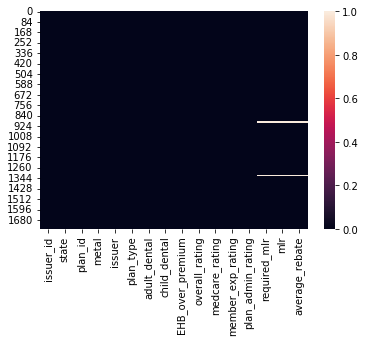

In [39]:
sns.heatmap(final.isnull())

In [40]:
len(final[final['mlr'].isna()])

21

In [41]:
data = final.dropna()
data

,issuer_id,state,plan_id,metal,issuer,plan_type,adult_dental,child_dental,EHB_over_premium,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating,required_mlr,mlr,average_rebate
0,10091,OR,10091OR0680001,Catastrophic,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
1,10091,OR,10091OR0680002,Bronze,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
2,10091,OR,10091OR0680003,Silver,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
3,10091,OR,10091OR0680004,Gold,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
4,10091,OR,10091OR0680005,Catastrophic,PacificSource Health Plans,PPO,0,0,0.9999,3,3,3,4,0.8,85.1%,$0 (Meets MLR Standard)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,99969,OH,99969OH0080113,Silver,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)
1749,99969,OH,99969OH0080114,Expanded Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)
1750,99969,OH,99969OH0080115,Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)
1751,99969,OH,99969OH0080116,Bronze,Medical Health Insuring Corp. of Ohio,HMO,0,0,1.0000,3,3,3,3,0.8,89.4%,$0 (Meets MLR Standard)


In [42]:
data = data.drop('required_mlr', axis=1)

In [43]:
data['mlr'] = percent2float(data['mlr'])


In [44]:
moneys = []
for x in data['average_rebate']:
    
    if "Meets MLR Standard" in x:
        moneys.append('$0')
    else:
        moneys.append(x)
data['average_rebate'] = moneys

In [45]:
set(data['average_rebate'])

{'$0',
 '$1,032',
 '$1,979',
 '$118',
 '$138',
 '$163',
 '$165',
 '$198',
 '$252',
 '$291',
 '$298',
 '$310',
 '$339',
 '$345',
 '$364',
 '$375',
 '$385',
 '$39',
 '$41',
 '$435',
 '$449',
 '$501',
 '$54',
 '$565',
 '$596',
 '$607',
 '$63',
 '$662',
 '$697',
 '$698',
 '$7',
 '$703',
 '$750',
 '$8',
 '$811',
 '$867',
 '$99'}

In [46]:
data['average_rebate'] = money2int(data['average_rebate'])

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732 entries, 0 to 1752
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   issuer_id          1732 non-null   int64  
 1   state              1732 non-null   object 
 2   plan_id            1732 non-null   object 
 3   metal              1732 non-null   object 
 4   issuer             1732 non-null   object 
 5   plan_type          1732 non-null   object 
 6   adult_dental       1732 non-null   int64  
 7   child_dental       1732 non-null   int64  
 8   EHB_over_premium   1732 non-null   float64
 9   overall_rating     1732 non-null   int64  
 10  medcare_rating     1732 non-null   int64  
 11  member_exp_rating  1732 non-null   int64  
 12  plan_admin_rating  1732 non-null   int64  
 13  mlr                1732 non-null   float64
 14  average_rebate     1732 non-null   int64  
dtypes: float64(2), int64(8), object(5)
memory usage: 216.5+ KB


### Correlation and Finding Relationships ###

overall_rating  correlation with metrics: 
EHB_over_premium   -0.149440
overall_rating      1.000000
mlr                 0.251736
Name: overall_rating, dtype: float64 

medcare_rating  correlation with metrics: 
EHB_over_premium   -0.136278
medcare_rating      1.000000
mlr                 0.339058
Name: medcare_rating, dtype: float64 

member_exp_rating  correlation with metrics: 
EHB_over_premium    -0.133120
member_exp_rating    1.000000
mlr                  0.236821
Name: member_exp_rating, dtype: float64 

plan_admin_rating  correlation with metrics: 
EHB_over_premium    -0.211678
plan_admin_rating    1.000000
mlr                  0.390296
Name: plan_admin_rating, dtype: float64 



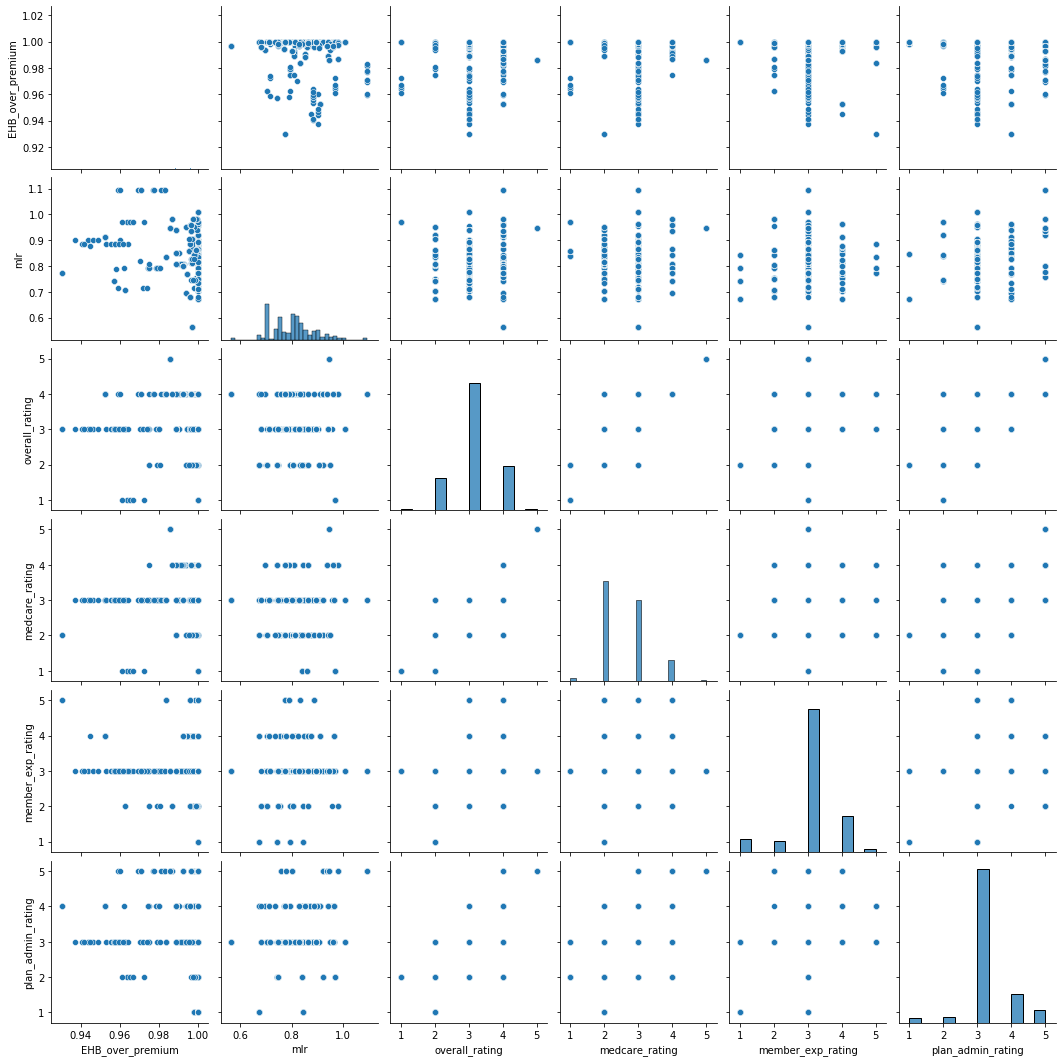

In [51]:
#linear correlation
ratings = ['overall_rating', 'medcare_rating', 'member_exp_rating', 'plan_admin_rating']

for rating in ratings:
    print(rating, ' correlation with metrics: ')
    print(data[['EHB_over_premium', rating, 'mlr']].corr()[rating], '\n')

    
sns.pairplot(data = data[['EHB_over_premium', 'mlr', 'overall_rating', 'medcare_rating', 'member_exp_rating', 'plan_admin_rating']])

In [49]:
#dcor.distance_correlation(a,b)

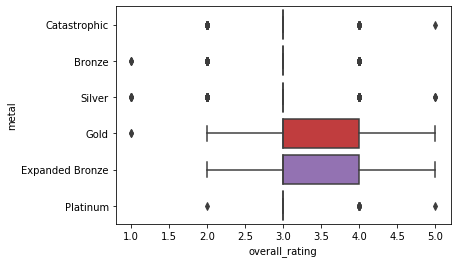

In [82]:
sns.boxplot(data = data, x = "overall_rating", y = "metal")

(-0.28454212367582127, 1.2836586230781855e-33)
(-0.14944005524785536, 4.1064244210145736e-10)
(0.251735777604563, 1.9243885086677498e-26)


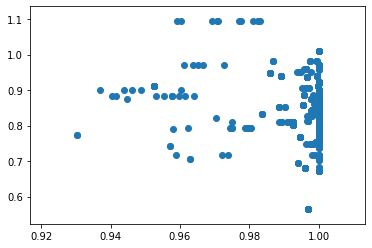

In [58]:
print(pearsonr(data['EHB_over_premium'], data['mlr']))
print(pearsonr(data['EHB_over_premium'], data['overall_rating']))
print(pearsonr(data['overall_rating'], data['mlr']))

Text(0.5, 0, 'EHB Over Premium')

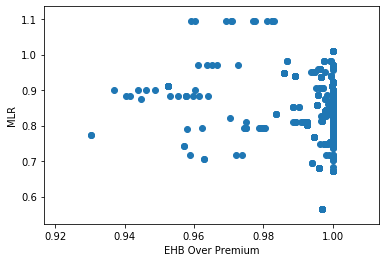

In [133]:
plt.scatter(data['EHB_over_premium'], data['mlr'])
plt.ylabel('MLR')
plt.xlabel('EHB Over Premium')

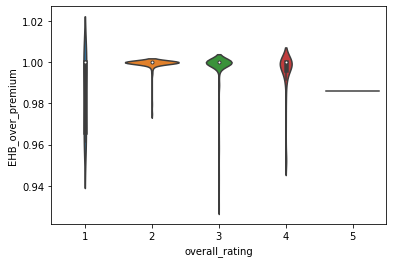

In [130]:
sns.violinplot(data = data, x = 'overall_rating', y = 'EHB_over_premium')
plt.ylabel('MLR')
plt.xlabel('Overall Rating')

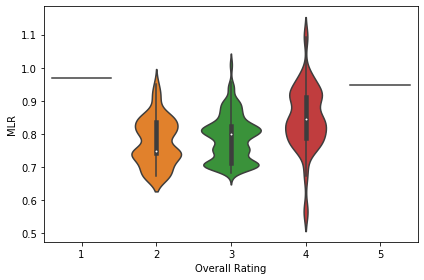

In [132]:
sns.violinplot(data = data, x = 'overall_rating', y = 'mlr')
plt.title('')
plt.ylabel('MLR')
plt.xlabel('Overall Rating')
plt.tight_layout()

In [126]:
X = sm.add_constant(data[['adult_dental', 'child_dental', 'EHB_over_premium', 'mlr', 'average_rebate']])
model = sm.OLS(data['overall_rating'], X)

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     29.90
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           3.23e-29
Time:                        22:51:24   Log-Likelihood:                -1622.6
No. Observations:                1732   AIC:                             3257.
Df Residuals:                    1726   BIC:                             3290.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6784      2.692      0.623      0.533      -3.602       6.959
adult_dental         0.2994      0.132      2.269      0.023       0.041       0.558
child_dental        -0.0049      0.035     -0.141      0.888      -0.073       0.063
EHB_over_premium    -0.8708      2.640     -0.330      0.742      -6.048       4.306
mlr                  2.7169      0.328      8.293      0.000       2.074       3.359
average_rebate       0.0003   8.91e-05      3.343      0.001       0.000       0.000
==============================================================================
Omnibus:                      115.253   Durbin-Watson:                   0.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.484
Skew:                          -0.507   Prob(JB):                     4.33e-42
Kurtosis:                       4.269   Cond. No.                     9.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [128]:
X = sm.add_constant(data[['adult_dental', 'mlr', 'average_rebate']])
model = sm.OLS(data['overall_rating'], X)

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     49.84
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           6.84e-31
Time:                        22:52:35   Log-Likelihood:                -1622.6
No. Observations:                1732   AIC:                             3253.
Df Residuals:                    1728   BIC:                             3275.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7856      0.271      2.902      0.004       0.255       1.317
adult_dental       0.3271      0.089      3.683      0.000       0.153       0.501
mlr                2.7420      0.320      8.564      0.000       2.114       3.370
average_rebate     0.0003    8.4e-05      3.629      0.000       0.000       0.000
==============================================================================
Omnibus:                      117.460   Durbin-Watson:                   0.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.923
Skew:                          -0.514   Prob(JB):                     4.71e-43
Kurtosis:                       4.283   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Analysis with aggregated data #

In [94]:
agg = df.groupby(by = ['state', 'issuer_id']).mean()
agg

adult_dental  child_dental  EHB_over_premium  overall_rating  \
state issuer_id                                                                 
AK    38344          0.000000           1.0          0.980400             3.0   
AL    46944          0.000000           1.0          1.000000             3.0   
AR    62141          0.000000           0.0          0.980057             3.0   
      75293          0.000000           0.0          0.996333             4.0   
AZ    53901          0.000000           1.0          1.000000             2.0   
...                       ...           ...               ...             ...   
WI    81413          0.000000           0.0          1.000000             4.0   
      86584          0.000000           0.0          1.000000             3.0   
      94529          0.000000           0.0          0.992500             4.0   
WV    50328          0.454545           1.0          0.984527             1.0   
WY    11269          0.000000           1.0          1.000000             2.0   

                 medcare_rating  member_exp_rating  plan_admin_rating  
state issuer_id                                                        
AK    38344                 3.0                3.0                3.0  
AL    46944                 3.0                4.0                3.0  
AR    62141                 2.0                5.0                4.0  
      75293                 2.0                5.0                4.0  
AZ    53901                 2.0                1.0                3.0  
...                         ...                ...                ...  
WI    81413                 4.0                4.0                5.0  
      86584                 3.0                3.0                3.0  
      94529                 3.0                4.0                5.0  
WV    50328                 1.0                3.0                2.0  
WY    11269                 1.0                3.0                2.0  

[97 rows x 7 columns]

In [96]:
aggfinal = agg.merge(mlr, on = ['issuer_id', 'state'], how = 'left')
aggfinal

,issuer_id,state,adult_dental,child_dental,EHB_over_premium,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating,required_mlr,mlr,average_rebate
0,38344,AK,0.000000,1.0,0.980400,3.0,3.0,3.0,3.0,0.8,71.6%,$662
1,46944,AL,0.000000,1.0,1.000000,3.0,3.0,4.0,3.0,0.8,84.8%,$0 (Meets MLR Standard)
2,62141,AR,0.000000,0.0,0.980057,3.0,2.0,5.0,4.0,0.8,77.4%,$99
3,75293,AR,0.000000,0.0,0.996333,4.0,2.0,5.0,4.0,0.8,88.7%,$0 (Meets MLR Standard)
4,53901,AZ,0.000000,1.0,1.000000,2.0,2.0,1.0,3.0,0.8,74.2%,$385
...,...,...,...,...,...,...,...,...,...,...,...,...
92,81413,WI,0.000000,0.0,1.000000,4.0,4.0,4.0,5.0,0.8,77.7%,$198
93,86584,WI,0.000000,0.0,1.000000,3.0,3.0,3.0,3.0,0.8,86.5%,$0 (Meets MLR Standard)
94,94529,WI,0.000000,0.0,0.992500,4.0,3.0,4.0,5.0,0.8,80.2%,$0 (Meets MLR Standard)
95,50328,WV,0.454545,1.0,0.984527,1.0,1.0,3.0,2.0,0.8,97.0%,$0 (Meets MLR Standard)


In [97]:
aggfinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 96
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   issuer_id          97 non-null     int64  
 1   state              97 non-null     object 
 2   adult_dental       97 non-null     float64
 3   child_dental       97 non-null     float64
 4   EHB_over_premium   97 non-null     float64
 5   overall_rating     97 non-null     float64
 6   medcare_rating     97 non-null     float64
 7   member_exp_rating  97 non-null     float64
 8   plan_admin_rating  97 non-null     float64
 9   required_mlr       95 non-null     float64
 10  mlr                95 non-null     object 
 11  average_rebate     95 non-null     object 
dtypes: float64(8), int64(1), object(3)
memory usage: 9.9+ KB


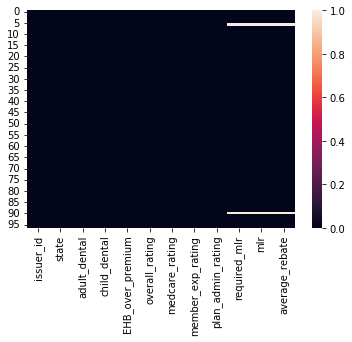

In [98]:
sns.heatmap(aggfinal.isnull())

In [101]:
aggfinal[aggfinal.isna().any(axis=1)]

,issuer_id,state,adult_dental,child_dental,EHB_over_premium,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating,required_mlr,mlr,average_rebate
6,76168,DE,0.0,1.0,1.0,3.000000,3.000000,3.000000,3.0,NaN,NaN,NaN
90,38345,WI,0.0,0.0,1.0,3.642857,3.642857,3.642857,3.0,NaN,NaN,NaN


In [102]:
aggfinal = aggfinal.dropna()

In [105]:
aggfinal = aggfinal.drop('required_mlr', axis=1)

In [106]:
aggfinal['mlr'] = percent2float(aggfinal['mlr'])
moneys = []
for x in aggfinal['average_rebate']:
    
    if "Meets MLR Standard" in x:
        moneys.append('$0')
    else:
        moneys.append(x)
aggfinal['average_rebate'] = moneys
aggfinal['average_rebate'] = money2int(aggfinal['average_rebate'])

In [118]:
aggfinal

,issuer_id,state,adult_dental,child_dental,EHB_over_premium,overall_rating,medcare_rating,member_exp_rating,plan_admin_rating,mlr,average_rebate
0,38344,AK,0.000000,1.0,0.980400,3.0,3.0,3.0,3.0,0.716,662
1,46944,AL,0.000000,1.0,1.000000,3.0,3.0,4.0,3.0,0.848,0
2,62141,AR,0.000000,0.0,0.980057,3.0,2.0,5.0,4.0,0.774,99
3,75293,AR,0.000000,0.0,0.996333,4.0,2.0,5.0,4.0,0.887,0
4,53901,AZ,0.000000,1.0,1.000000,2.0,2.0,1.0,3.0,0.742,385
...,...,...,...,...,...,...,...,...,...,...,...
92,81413,WI,0.000000,0.0,1.000000,4.0,4.0,4.0,5.0,0.777,198
93,86584,WI,0.000000,0.0,1.000000,3.0,3.0,3.0,3.0,0.865,0
94,94529,WI,0.000000,0.0,0.992500,4.0,3.0,4.0,5.0,0.802,0
95,50328,WV,0.454545,1.0,0.984527,1.0,1.0,3.0,2.0,0.970,0


In [124]:
X = sm.add_constant(aggfinal[['adult_dental', 'child_dental', 'EHB_over_premium', 'mlr', 'average_rebate']])
model = sm.OLS(aggfinal['overall_rating'], X)

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.421
Date:                Mon, 17 Apr 2023   Prob (F-statistic):              0.225
Time:                        22:50:15   Log-Likelihood:                -102.59
No. Observations:                  95   AIC:                             217.2
Df Residuals:                      89   BIC:                             232.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.7975     14.625      0.260      0.796     -25.262      32.857
adult_dental         0.6426      0.556      1.155      0.251      -0.463       1.748
child_dental         0.1048      0.174      0.603      0.548      -0.241       0.450
EHB_over_premium    -2.3008     14.347     -0.160      0.873     -30.807      26.205
mlr                  1.6695      1.427      1.170      0.245      -1.167       4.506
average_rebate       0.0007      0.000      1.781      0.078   -7.84e-05       0.001
==============================================================================
Omnibus:                        4.163   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.467
Skew:                          -0.427   Prob(JB):                        0.177
Kurtosis:                       3.382   Cond. No.                     9.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
ratings = ['overall_rating', 'medcare_rating', 'member_exp_rating', 'plan_admin_rating']

for rating in ratings:
    print(rating, ' correlation with metrics: ')
    print(aggfinal[['EHB_over_premium', rating, 'mlr']].corr()[rating], '\n')

    


overall_rating  correlation with metrics: 
EHB_over_premium   -0.135707
overall_rating      1.000000
mlr                 0.030057
Name: overall_rating, dtype: float64 

medcare_rating  correlation with metrics: 
EHB_over_premium   -0.123128
medcare_rating      1.000000
mlr                 0.056812
Name: medcare_rating, dtype: float64 

member_exp_rating  correlation with metrics: 
EHB_over_premium    -0.149174
member_exp_rating    1.000000
mlr                  0.097929
Name: member_exp_rating, dtype: float64 

plan_admin_rating  correlation with metrics: 
EHB_over_premium    -0.183675
plan_admin_rating    1.000000
mlr                  0.231574
Name: plan_admin_rating, dtype: float64 



In [117]:
print(pearsonr(aggfinal['EHB_over_premium'], aggfinal['mlr']))
print(pearsonr(aggfinal['EHB_over_premium'], aggfinal['overall_rating']))
print(pearsonr(aggfinal['overall_rating'], aggfinal['mlr']))
print(pearsonr(aggfinal['plan_admin_rating'], aggfinal['mlr']))

(-0.2530400775412232, 0.013357785898446054)
(-0.13570659019049047, 0.1897668592646803)
(0.030056594114325964, 0.772472288779372)
(0.23157388568058118, 0.023945030204651788)


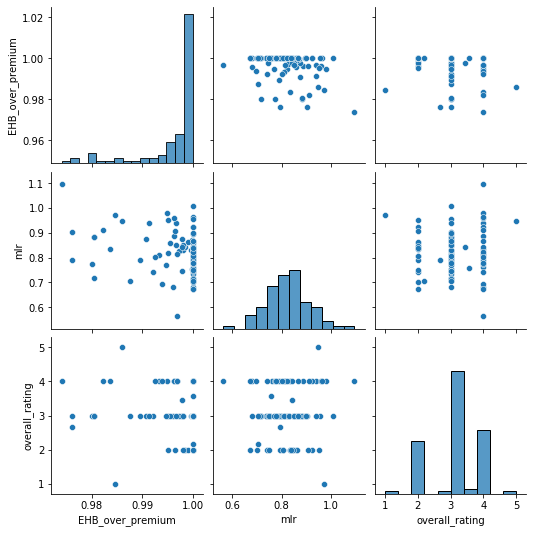

In [112]:
sns.pairplot(aggfinal[['EHB_over_premium', 'mlr', 'overall_rating']])

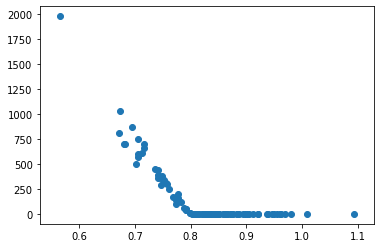

In [116]:
plt.scatter(aggfinal['mlr'], aggfinal['average_rebate'])